In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import itertools

In [2]:
# Load the connecitvity data as a dataframe
DataDir= '/home/jovyan/data/connectivityml/HCP_PTN1200/netmats'

# Load connecitivty data as dictionaries
Folders_list = os.listdir(DataDir)
Conn_data1 = dict();
Conn_data2 = dict();
j=0; Nodes = list();
for flds in Folders_list:
    Nodes.append(flds.split("_")[3])
    net1 = np.loadtxt(os.path.join(DataDir,flds,'netmats1.txt'))
    net2 = np.loadtxt(os.path.join(DataDir,flds,'netmats2.txt'))
    N  = int(Nodes[j][1:])
    indx = np.triu_indices(N,1)
    mat1 = np.transpose(np.transpose(net1.reshape(1003,N,N),[1,2,0])[indx],[1,0])
    mat2 = np.transpose(np.transpose(net2.reshape(1003,N,N),[1,2,0])[indx],[1,0])
    Conn_data1[Nodes[j]] = mat1
    Conn_data2[Nodes[j]] = mat2
    j=j+1



# Loading the behavioral data
Behv_data_df = pd.read_csv('/home/jovyan/ML-Proj/unrestricted_pkalra_7_26_2021_17_39_25.csv')

# Loading Subject IDs
SubjectID= np.loadtxt("/home/jovyan/ML-Proj/subjectIDs.txt")


In [3]:
#Loading and selecting subjects in behavioral data based on available RS data
Behv_data_df = pd.read_csv('/home/jovyan/ML-Proj/unrestricted_pkalra_7_26_2021_17_39_25.csv')
Behv_data_df = Behv_data_df.set_index('Subject')
Behv_data_df = Behv_data_df.loc[SubjectID,:]

In [4]:
# Choosing a predictor (We chose gender)
y= Behv_data_df["Gender"]
y= y.to_numpy()

In [5]:
# Optimization using nested CV

hyp1 = dict();
hyp2 = dict();
hyp1['C'] =[0.1,1,10] # Hyperparameters for SVM
hyp2['n_estimators'] = [1,10,100] # Hyperparameters for SVM

SVM_results_IC1= dict();
RF_results_IC1= dict();
SVM_results_IC2= dict();
RF_results_IC2= dict();

for j in np.arange(len(Folders_list)):
    X1= Conn_data1[Nodes[j]]
    X2= Conn_data2[Nodes[j]]
    clf1 = svm.SVC(kernel='linear')
    clf2 = RandomForestClassifier(max_depth =2)
    outer_cv = KFold(n_splits=3, shuffle=True)
    SVM_results1= list()
    RF_results1= list()
    SVM_results2= list()
    RF_results2= list()
    for train_ix, test_ix in outer_cv.split(X1):
        # split data into train, test for outer CV
        X1_train, X1_test = X1[train_ix], X1[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        X2_train, X2_test = X2[train_ix], X2[test_ix]
        inner_cv=  KFold(n_splits=3, shuffle=True)       
        Search1 = GridSearchCV(estimator=clf1,scoring='accuracy', param_grid=hyp1, cv=inner_cv,refit=True)
        Search2 = GridSearchCV(estimator=clf2,scoring='accuracy', param_grid=hyp2, cv=inner_cv,refit=True)
        # execute search
        resultSVM1 =  Search1.fit(X1_train, y_train)
        resultRF1 =  Search2.fit(X1_train, y_train)
        resultSVM2 =  Search1.fit(X2_train, y_train)
        resultRF2 =  Search2.fit(X2_train, y_train)
        # get the best performing model fit on the whole training set
        best_SVMmodel1 = resultSVM1.best_estimator_
        best_SVMmodel2 = resultSVM2.best_estimator_
        best_RFmodel1 = resultRF1.best_estimator_
        best_RFmodel2 = resultRF2.best_estimator_
        # evaluate the best model on the hold out dataset
        yhatSVM1 = best_SVMmodel1.predict(X1_test)
        yhatRF1 = best_RFmodel1.predict(X1_test)
        yhatSVM2= best_SVMmodel2.predict(X2_test)
        yhatRF2= best_RFmodel2.predict(X2_test)
        # Calculate the accuracy
        SVMacc1= accuracy_score(y_test,yhatSVM1)
        RFacc1= accuracy_score(y_test, yhatRF1)
        SVMacc2= accuracy_score(y_test,yhatSVM2)
        RFacc2= accuracy_score(y_test, yhatRF2)
        # store the result for each method
        SVM_results1.append(SVMacc1)
        RF_results1.append(RFacc1)
        SVM_results2.append(SVMacc2)
        RF_results2.append(RFacc2)
        
    # store the results for all IC parcellations
    SVM_results_IC1[Nodes[j]]= SVM_results1
    RF_results_IC1[Nodes[j]]= RF_results1
    SVM_results_IC2[Nodes[j]]= SVM_results2
    RF_results_IC2[Nodes[j]]= RF_results2


In [8]:
# Tabulating the results
SVMacc1 =  pd.DataFrame(SVM_results_IC1)
RFacc1 =  pd.DataFrame(RF_results_IC1)
SVMacc2 =  pd.DataFrame(SVM_results_IC2)
RFacc2=  pd.DataFrame(RF_results_IC2)
SVMacc1.index = hyp1['C']
SVMacc2.index = hyp1['C']
RFacc1.index = hyp2['n_estimators']
RFacc2.index = hyp2['n_estimators']
print("\n Correlation\n")
print("SVM\n")
print(SVMacc1)
print("\nRF\n")
print(RFacc1)
print("\n Partial correlation\n")
print("SVM\n")
print(SVMacc2)
print("\nRF\n")
print(RFacc2)


 Correlation

SVM

          d300       d25       d50       d15      d100      d200
0.1   0.910448  0.680597  0.832836  0.620896  0.683582  0.880597
1.0   0.883234  0.718563  0.865269  0.673653  0.865269  0.904192
10.0  0.868263  0.712575  0.760479  0.592814  0.838323  0.826347

RF

         d300       d25       d50       d15      d100      d200
1    0.519403  0.680597  0.608955  0.662687  0.722388  0.617910
10   0.556886  0.601796  0.655689  0.637725  0.655689  0.628743
100  0.655689  0.619760  0.652695  0.616766  0.661677  0.562874

 Partial correlation

SVM

          d300       d25       d50       d15      d100      d200
0.1   0.976119  0.826866  0.931343  0.764179  0.964179  0.964179
1.0   0.979042  0.820359  0.922156  0.775449  0.958084  0.964072
10.0  0.949102  0.835329  0.907186  0.763473  0.961078  0.967066

RF

         d300       d25       d50       d15      d100      d200
1    0.728358  0.731343  0.725373  0.710448  0.820896  0.802985
10   0.766467  0.646707  0.706587  0.6

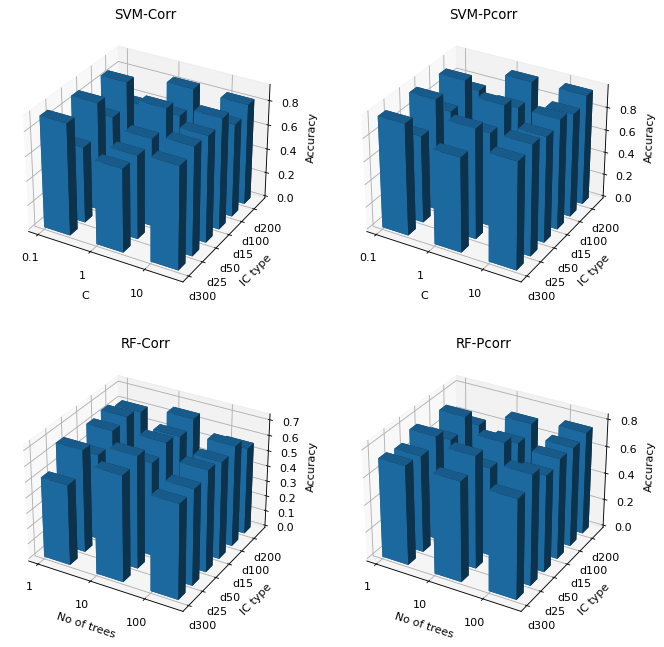

In [10]:
# Plotting the results using 3D barplots
fig = plt.figure(figsize=(10,10),dpi=80)
ax1= fig.add_subplot(2,2,1, projection='3d')
ax2= fig.add_subplot(2,2,2, projection='3d')
ax3= fig.add_subplot(2,2,3, projection='3d')
ax4= fig.add_subplot(2,2,4, projection='3d')

lx1= len(hyp1['C'] )
ly = len(Nodes)
lx2= len(hyp2['n_estimators'])

xpos1= np.arange(0, lx1,1)
xpos2= np.arange(0, lx2,1)
ypos= np.arange(0, ly, 1)
xpos1g,yposg=  np.meshgrid(xpos1,ypos)
xpos2g,yposg=  np.meshgrid(xpos2,ypos)


# Setting x, y and z positions
xpos1g = xpos1g.flatten()
yposg= yposg.flatten()
xpos2g = xpos2g.flatten()
zpos1g=np.zeros(lx1*ly)
zpos2g=np.zeros(lx2*ly)

# Making the depths 
dx1= 0.5*np.ones_like(zpos1g)
dx2= 0.5*np.ones_like(zpos2g)
dy1= 0.5*np.ones_like(zpos1g)
dy2= 0.5*np.ones_like(zpos2g)

dz11=SVMacc1.values.flatten()
dz12=SVMacc2.values.flatten()
dz21=RFacc1.values.flatten()
dz22=RFacc2.values.flatten()


ax1.bar3d(xpos1g,yposg,zpos1g,dx1,dy1,dz11)
ax2.bar3d(xpos1g,yposg,zpos1g,dx1,dy1,dz12)
ax3.bar3d(xpos2g,yposg,zpos2g,dx2,dy2,dz21)
ax4.bar3d(xpos2g,yposg,zpos2g,dx2,dy2,dz22)

ax1.w_xaxis.set_ticks(np.arange(lx1))
ax1.w_xaxis.set_ticklabels(hyp1['C'])
ax1.w_yaxis.set_ticks(np.arange(ly))
ax1.w_yaxis.set_ticklabels(Nodes)

ax2.w_xaxis.set_ticks(np.arange(lx1))
ax2.w_xaxis.set_ticklabels(hyp1['C'])
ax2.w_yaxis.set_ticks(np.arange(ly))
ax2.w_yaxis.set_ticklabels(Nodes)

ax3.w_xaxis.set_ticks(np.arange(lx2))
ax3.w_xaxis.set_ticklabels(hyp2['n_estimators'])
ax3.w_yaxis.set_ticks(np.arange(ly))
ax3.w_yaxis.set_ticklabels(Nodes)

ax4.w_xaxis.set_ticks(np.arange(lx2))
ax4.w_xaxis.set_ticklabels(hyp2['n_estimators'])
ax4.w_yaxis.set_ticks(np.arange(ly))
ax4.w_yaxis.set_ticklabels(Nodes)


ax1.set_xlabel('C')
ax1.set_ylabel('IC type')
ax1.set_zlabel('Accuracy')
ax1.title.set_text('SVM-Corr')

ax2.set_xlabel('C')
ax2.set_ylabel('IC type')
ax2.set_zlabel('Accuracy')
ax2.title.set_text('SVM-Pcorr')

ax3.set_xlabel('No of trees')
ax3.set_ylabel('IC type')
ax3.set_zlabel('Accuracy')
ax3.title.set_text('RF-Corr')

ax4.set_xlabel('No of trees')
ax4.set_ylabel('IC type')
ax4.set_zlabel('Accuracy')
ax4.title.set_text('RF-Pcorr')


plt.show()